How to print weight for convLSTM?

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
import random
import torch.nn as nn
import pandas as pd
from ConvLSTM_pytorch import convlstm
import operator
from utils_v4 import *

# Data Files

In [2]:
#selected subset of dates. 
val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/'
model_saving_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models'




## Load data helper functions

In [3]:
def create_files_new(load_path, bad_dates, T_length=10, proceed=1): 
    sleep_files = os.listdir(load_path+'sleep/')
    move_files = os.listdir(load_path+'move/')
    all_files = sleep_files+move_files
    
    dic = {}
    for f in all_files:
        mvmt_type = f.split('_')[-1].split('.')[0]
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        time = float(f.split('_')[3][4:])
        if date in bad_dates:
            continue
        if mvmt_type == 'sleep':
            label = 1
        else:
            label = 0
        if date in dic:
            if rec in dic[date]:
                dic[date][rec].append([f, label, mvmt_type, date, rec, time])
            else:
                dic[date][rec] = [[f, label, mvmt_type, date, rec, time]]
        else:
            dic[date] = {rec: [[f, label, mvmt_type, date, rec, time]]}
        
    for d in dic:
        for r in dic[d]:
            dic[d][r] = sorted(dic[d][r], key=operator.itemgetter(3, 4, 5))
    
    move_data, sleep_data = [], []
    for d in dic:
        for r in dic[d]:
            sleep_grouped, move_grouped = create_files_new_helper(dic[d][r], T_length=T_length, proceed=proceed)
            sleep_data.append(sleep_grouped)
            move_data.append(move_grouped)
    
    return move_data, sleep_data

In [4]:
def create_files_new_helper(L, T_length, proceed):
    L_labels = np.array([L[i][1] for i in range(len(L))])
    L_times = np.array([L[i][-1] for i in range(len(L))])
    
    L_new_sleep, L_new_move = [], []
    start = 0
    while start <= len(L)-T_length:
        end = start + T_length
        #pdb.pm()
        if sum(L_times[start+1:end]-L_times[start:end-1]-time_window) != 0:
            start += 1
            continue
        if sum(L_labels[start:end]) == T_length:
            L_new_sleep.append(L[start:end])
        elif sum(L_labels[start:end]) == 0:
            L_new_move.append(L[start:end])
        start += proceed
    return L_new_sleep, L_new_move

In [5]:
def upsample(train_files):
    train_sleep = [i for i in train_files if i[0][1] == 1]
    train_move = [i for i in train_files if i[0][1] == 0]
    diff = abs(len(train_sleep)-len(train_move))
    train_new = []
    d = 0
    while d < diff:
        if len(train_sleep) > len(train_move):
            ind = random.randint(0, len(train_move)-1)
            x = train_move[ind]
            d += 1
        else:
            ind = random.randint(0, len(train_sleep)-1)
            x = train_sleep[ind]
            d += 1
        train_new.append(x)   
    train_files = train_sleep+train_move+train_new
    return train_files

In [6]:
class SpectrogramDatasetAtt(Dataset):
    def __init__(self, files, load_path, T_length, all_label=False, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
        self.T_length = T_length
        self.all_label = all_label
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        group = self.files[idx]
        specs, labels, dates, recs, times = [], [], [], [], []
        for i in range(len(group)):
            f, label, mvmt_type, date, rec, time = group[i]
            spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f))
            if self.CH is not None:
                spec = torch.transpose(spec[self.CH,:,:].unsqueeze(0), 2, 1)
            else:
                spec = torch.transpose(spec, 2, 1)
            specs.append(spec)
            labels.append(torch.Tensor([label]))
            dates.append(date)
            recs.append(rec)
            times.append(time)
            if i == (self.T_length-1)/2:
                label_mid = torch.Tensor([label])
                date_mid = date
                rec_mid = rec
                time_mid = time
        if self.all_label:
            return specs, labels, dates, recs, times
        else:
            return specs, label_mid, date_mid, rec_mid, time_mid

# Load data: T_length = 3

In [7]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=3)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [8]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [9]:
## Upsample train
train_files = upsample(train_files)

In [10]:
len(train_files), len(val_files), len(test_files)

(6092, 1880, 1870)

In [11]:
## Load files to dataloader
CH = 23
# CH = None
train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=True, CH = CH)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=True, CH = CH)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=True, CH = CH)

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=False, CH=CH)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=False, CH=CH)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

## convLSTM

In [13]:
## Define Model
class convLSTM(nn.Module):
    def __init__(self, input_dim = 1, layers = 1, hidden_dim = 10, frequencies = 100,timewindow = 10, output_size=1, batch_size=128):
        super(convLSTM, self).__init__()
        
        self.input_dim = input_dim
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = layers
        self.hidden_dim = hidden_dim
        self.freqs = frequencies
        self.timewindow = timewindow
        
        # Define the lstm layer
        self.convLSTM = convlstm.ConvLSTM(input_dim=self.input_dim,
                 hidden_dim=self.hidden_dim,
                 kernel_size=(3, 3),
                 num_layers=self.n_layers,
                 batch_first=False,
                 bias=True,
                 return_all_layers=False)
        # Define the fully-connected layer
        self.fc = nn.Linear(self.hidden_dim*self.freqs*self.timewindow, output_size)

    def forward(self, input_seq):
        
        # convLSTM
        _, last_states = self.convLSTM(input_seq)
        last_states = last_states[0][0]
        last_states = last_states.reshape(last_states.shape[0], -1)
        fc = self.fc(last_states)        

        return fc

### Training functions

In [14]:
def get_accuracy(model, loader, device='cuda', collect_result = False):
    """
    Function that calculate the accuracy of the model. 
    """
    correct = 0
    total = 0
    pred, labs = [],[]
    with torch.no_grad():
        for data, labels, _, _, _ in loader:
            # Labels
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            # Data
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            # Feed data to model
            outputs = model(data)            
            outputs = torch.tensor(outputs).to(device)
            # Predictions
            predictions = (outputs > 0.5) * 1.0
            predictions = predictions.flatten().detach().cpu().numpy()
            labels = labels.flatten().cpu().numpy()
            # Calculate Accuracy
            total += len(labels)
            correct += (predictions == labels).sum()
            
            if collect_result:
                pred.append(predictions)
                labs.append(labels)
            
    accuracy = correct / total
    if collect_result:
        return accuracy, pred, labs
    return accuracy

In [15]:
def train(model, optimizer, criterion, loader, device='cuda'):
    """
    Function that train the model. 
    """
    model.train()
    epoch_losses = 0
    epoch_lens = 0
    parameter_history = []
    # criterion = nn.BCELoss()
    for batch_idx, (data, labels, _, _, _) in enumerate(loader):
        # Get Label
        labels = torch.stack(labels)
        labels = labels[0]
        labels = torch.flatten(labels).to(device).float()
        labels = labels.to(device).float()
#         print(batch_idx)
        
        # Get data
        data = torch.tensor(np.stack(data)).to(device).float() 
        data = data.to(device).float()

        # Zero out grad
        optimizer.zero_grad()

        # Data in model
        outputs = model(data)
#         outputs = torch.tensor(outputs,requires_grad = True).to(device)
        outputs = torch.squeeze(outputs)

        # Get loss
        loss = criterion(torch.sigmoid(outputs), labels)
        print(loss)
        epoch_losses += loss
        epoch_lens += 1

        parameter_history.append(list(model.parameters())[0])
        loss.backward()
        optimizer.step()

    epoch_accs = get_accuracy(model, loader, device=device, collect_result = False)
    return epoch_losses/epoch_lens, epoch_accs, parameter_history

def evaluate(model, optimizer, criterion, loader, device='cuda', collect_result = False):
    model.eval()
    epoch_losses = 0
    epoch_lens = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, _, _, _) in enumerate(loader):
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            labels = torch.flatten(labels).to(device).float()
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            outputs = model(data)
#             outputs = torch.tensor(outputs).to(device)
            outputs = torch.squeeze(outputs)
            loss = criterion(torch.sigmoid(outputs), labels)
            epoch_losses += loss
            epoch_lens += 1
    
    if collect_result:
        epoch_accs, pred, labs = get_accuracy(model, loader, device = device, collect_result = True)
        return epoch_losses/epoch_lens,epoch_accs, pred, labs
    else:
        epoch_accs = get_accuracy(model, loader, device=device, collect_result = collect_result)
    return epoch_losses/epoch_lens, epoch_accs

### Training: T_length = 3

In [30]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.1
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 23
# verbose = False


model = convLSTM().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss() # BCE loss

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(11, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


tensor(0.6889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.3731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(49.4959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(30.9901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(22.8600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(20.6526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.2651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(38.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(31.1222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(25.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.8246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(40.9917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(38.3029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(

<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 26.12007713317871
Val loss for epoch 0: 18.957738876342773
tensor(45.5420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(47.6562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(46.8750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(34.3984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(55.4688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(52.3438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(46.0938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(39.8438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(48.4488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(33.7839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(32.4438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(27.6354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(34.4904, device='cuda:0', grad_fn=<BinaryCrossEntropyBac

tensor(17.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.1255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.1825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.7169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(20.1376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.1940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.4183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.0354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.2848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(21.3320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.4216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor

tensor(16.1081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.3125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(20.2582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(20.2259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.8304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.4801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.1587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.4128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.8222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.1294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.0458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.8438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.4138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Train loss for epoch 5: 16.343612670898438
Val loss for epoch 5: 11.020034790

tensor(18.8035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.6231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.7500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(19.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.3522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.6728, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(19.0218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.4625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.6598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.1979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.1099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(17.0503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.9605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(19.2057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(

tensor(29.6875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(30.5621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(36.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(28.1250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(21.0938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(22.8224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(19.8609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.4219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(24.2941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.2964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.4413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.0901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.2956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(

tensor(16.6815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.6262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.2168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.4287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.9901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.8699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(19.1539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Train loss for epoch 12: 17.90312957763672
Val loss for epoch 12: 6.943075180053711
tensor(14.0625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(17.6512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.4407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.8438, device='cuda:0', grad_fn=<BinaryCrossEntropyBack

tensor(13.2812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.3796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.7317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.1562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.4463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.3072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.9903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.8438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.6664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.9058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.0187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11

tensor(9.7126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.1694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.0796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.9459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.2106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.1277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.0866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.3037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.8187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.3407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.0229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.6934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.

tensor(18.0226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.4291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.7011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Train loss for epoch 19: 13.878157615661621
Val loss for epoch 19: 7.579695224761963
tensor(14.4465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.7264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.2812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(17.9688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.6873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(17.1875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.4084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.0222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.0524, device='cuda:0', grad_fn=<BinaryCrossEntropyBack

tensor(10.7097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.9385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(17.7158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.2766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.6543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.6264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(18.8363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1

tensor(15.7443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.6254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.0499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.4397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(17.4030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(23.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.4065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.2726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(17.3890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.3466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.1347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor

tensor(12.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.1027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.0995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.3867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.2787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.8886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(19.0854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.3495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.6507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.7191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.2451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.3410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.

tensor(13.2659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.9098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.7024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.3076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.3897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.2183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.9610, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.0949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.3555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.6126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.0

tensor(5.6231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.6270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.7198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.2472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.7032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.2829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.1447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.3750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.8421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Train loss for epoch 31: 8.983728408813477
Val loss for epoch 31: 8.35937786102295
tensor(9.9708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.2650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
te

tensor(11.5605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.0350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.2500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.3103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.5991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.6876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(15.8228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.3822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.4171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.3315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.3735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.3750

tensor(8.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.1564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.1854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.3515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.3493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.8406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.3750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.2954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.4970,

Train loss for epoch 38: 9.471054077148438
Val loss for epoch 38: 7.5477705001831055
tensor(7.8157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.1562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.4485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(14.8441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.0723, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.0858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.6880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.4688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.1539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.0293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
te

tensor(7.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(16.4063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.9525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(3.9064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(3.1250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.4715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.6875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.2522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.2500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.7715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.4619, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8125, d

tensor(7.0314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(3.0315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.6585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.6471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.7739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(11.1007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.1159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.2004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(13.2526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Train loss for epoch 43: 8.184383392333984
Val loss for epoch 43: 7.093423843383789
tensor(7.8144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.0315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tens

tensor(7.8125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.0430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(3.9063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.9375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.2500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.4688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(2.3438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.1617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.5581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.0325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.6734, dev

tensor(4.6934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.2500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.7015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.1562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.8125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.7281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.2128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(12.4043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.8948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.6875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.3750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.1127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(10.1563, d

Train loss for epoch 50: 7.0953898429870605
Val loss for epoch 50: 7.318913459777832


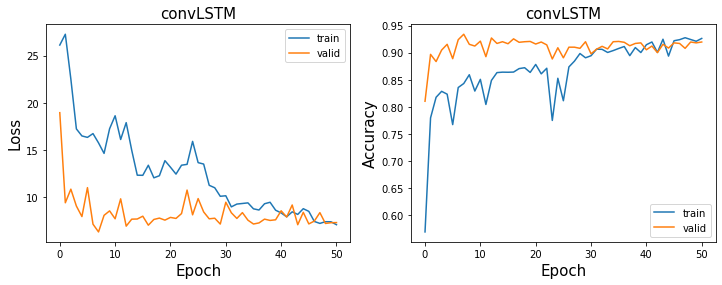

In [17]:
train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]
 
for epoch in range(num_epochs):
    train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
    val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, epoch))
#     elif verbose:
    else:
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        
#     if epoch == num_epochs-1:
#         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))

plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [31]:
train_result_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow)
print(train_result_filename)

/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CH23_LOSSbce_REGnone0_TW10_trainresult.pt


In [32]:
train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}

pickle.dump( train_result, open( train_result_filename, "wb" ) )

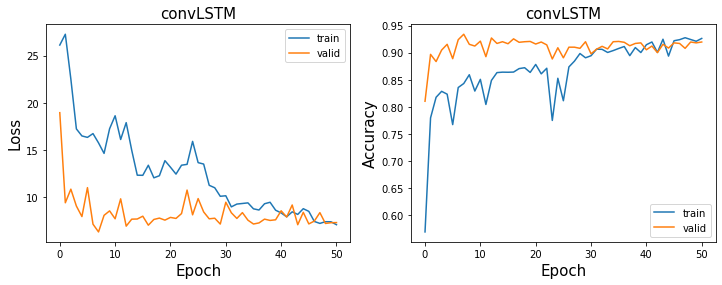

In [33]:
train_result = pickle.load(open(train_result_filename, "rb" ))
plot_loss_acc( train_result['train_losses'],  train_result['val_losses'],  train_result['train_accs'],  train_result['val_accs'],  train_result['model_type'])

In [19]:
model_convLSTM = os.listdir(model_saving_path)
results = []
best_result = 0
reg_alpha = 'REG'+reg_type+str(alpha)+'_'
for i, s in enumerate(model_convLSTM):
    if 'convLSTM_CH23_' in s and reg_alpha in s:
        model_name = model_convLSTM[i].split('_')
        epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
        res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
        if len(res) > 1:
            epoch_result = res[0]*10+res[1]
        else:
            epoch_result = res[0]
        if epoch_result>best_result and epoch_result != 50:
            best_result = epoch_result

results.append([alpha,best_result])

    
results = pd.DataFrame(np.array(results), columns=['alpha', 'epoch'])
best_results = results.groupby('alpha').max('epoch')
print(best_results)


       epoch
alpha       
0         36


/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/convLSTM_models/convLSTM_CH23_LOSSbce_REGnone0_TW10_EPOCH36.pt


<ipython-input-24-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:6.732386112213135 accuracy:0.9292553191489362


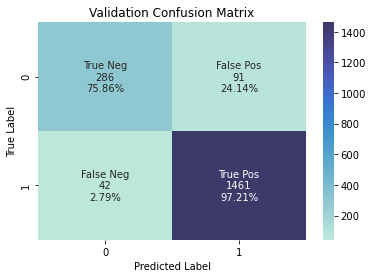

In [31]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    alpha = index
    
    
    # load best model
    model = convLSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, best_epoch))

    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
#     ## Calculate test accuracy and test loss
# #     test_loss, test_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
# #     print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
# #     print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)

    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
#     ## Confusion matrix-test
#     predictions_test = np.concatenate(test_preds)
#     labels_test = np.concatenate(test_labels)

#     df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

#     cm_test = confusion_matrix(labels_test, predictions_test)
#     ax = plt.axes()
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in
#                     cm_test.flatten()]

#     TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
#     FPR = 1 - TNR
#     TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
#     FNR = 1-TPR
#     group_percentages =[TNR, FPR, FNR, TPR]

#     group_percentages = ["{0:.2%}".format(value) for value in
#                          group_percentages]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names,group_counts,group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
#     ax.set_title('Test Confusion Matrix')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()
    


# Draft

In [16]:
# model = convlstm.ConvLSTM(input_dim=1,
#                  hidden_dim=10,
#                  kernel_size=(3, 3),
#                  num_layers=1,
#                  batch_first=False,
#                  bias=True,
#                  return_all_layers=False).to(device)


# print(model)

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(11, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


In [21]:
## Testing block: try if the model could work
(data, labels, _, _, _) = next(iter(train_loader))
labels = torch.stack(labels)
labels = labels[0]

labels = torch.flatten(labels).to(device).float()




data_multi = torch.tensor(np.stack(data)).to(device).float() 
data_multi.is_cuda
outputs = model(data_multi)
outputs = torch.squeeze(outputs)
outputs = torch.sigmoid(outputs)
criterion = nn.BCELoss()
data[0].shape



torch.Size([128, 1, 100, 10])